In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sys
import os

# Ensure we can import from Scripts
if os.path.isdir('Scripts'):
    sys.path.append('Scripts')

from vae import VAE, VAEEncoder
from deeptime.util.torch import MLP

In [4]:
# Load data
try:
    soap_saved = np.load("assets/test2npy.npy")
    print(f"Data loaded. Shape: {soap_saved.shape}")
except FileNotFoundError:
    print("Error: assets/test.npy not found. Please ensure the data file exists.")

Data loaded. Shape: (40, 8000, 324)


In [5]:
# Preprocessing
if 'soap_saved' in locals():
    data = np.concatenate(soap_saved)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    print(f"Scaled data shape: {scaled_data.shape}")

Scaled data shape: (320000, 324)


In [6]:
# Dataset Definition
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.data = torch.Tensor(data)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        # VAE.fit expects just the data tensor, not a tuple
        return self.data[idx]

In [7]:
# Data Splitting and Loaders
if 'scaled_data' in locals():
    # Split: 10% test, then 25% val from remaining
    train_val_data, test_data = train_test_split(scaled_data, test_size=0.1, random_state=42)
    train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

    train_loader = DataLoader(SimpleDataset(train_data), batch_size=256, shuffle=True)
    val_loader = DataLoader(SimpleDataset(val_data), batch_size=len(val_data), shuffle=False)

    print(f"Train samples: {len(train_data)}")
    print(f"Val samples: {len(val_data)}")

Train samples: 216000
Val samples: 72000


In [28]:
# Initialize Model
if 'scaled_data' in locals():
    units = [324, 1024, 256, 2]

    # Encoder
    encoder = VAEEncoder(units, nonlinearity=torch.nn.ELU)

    # Decoder (Reverse units)
    decoder = MLP(units[::-1], nonlinearity=torch.nn.ELU, initial_batchnorm=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    vae = VAE(encoder, decoder, beta=0.0, learning_rate=1e-4, device=device, early_stopping_patience=10)
    print("VAE Model Initialized")

Using device: cuda
VAE Model Initialized


In [29]:
# Train Model
if 'vae' in locals() and 'train_loader' in locals():
    vae.fit(train_loader, n_epochs=50, validation_loader=val_loader)
    vae_model = vae.fetch_model()

Epoch 1/50: Val loss improved to 102215.3594. Saving model.
Epoch 2/50: Val loss improved to 101430.8438. Saving model.
Epoch 3/50: Val loss did not improve from 101430.8438. Patience: 1/10
Epoch 4/50: Val loss did not improve from 101430.8438. Patience: 2/10
Epoch 5/50: Val loss did not improve from 101430.8438. Patience: 3/10
Epoch 6/50: Val loss improved to 100958.5938. Saving model.
Epoch 7/50: Val loss improved to 99963.2031. Saving model.
Epoch 8/50: Val loss did not improve from 99963.2031. Patience: 1/10
Epoch 9/50: Val loss improved to 99589.6875. Saving model.
Epoch 10/50: Val loss improved to 99036.6562. Saving model.
Epoch 11/50: Val loss did not improve from 99036.6562. Patience: 1/10
Epoch 12/50: Val loss improved to 99000.0156. Saving model.
Epoch 13/50: Val loss did not improve from 99000.0156. Patience: 1/10
Epoch 14/50: Val loss did not improve from 99000.0156. Patience: 2/10
Epoch 15/50: Val loss improved to 98523.1562. Saving model.
Epoch 16/50: Val loss did not imp

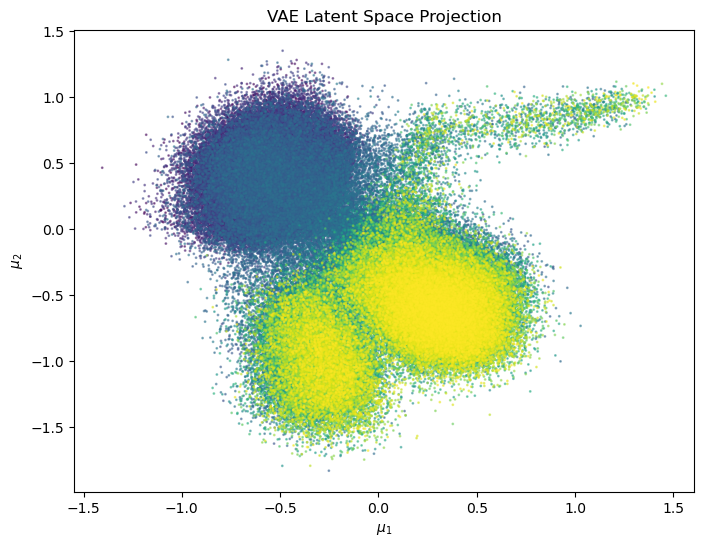

In [30]:
# Visualize Latent Space
if 'vae_model' in locals() and 'scaled_data' in locals():
    # Project entire dataset
    proj = vae_model.transform(scaled_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(proj[:, 0], proj[:, 1], s=1, alpha=0.5, c = np.arange(len(proj)))
    plt.xlabel(r"$\mu_1$")
    plt.ylabel(r"$\mu_2$")
    plt.title("VAE Latent Space Projection")
    plt.show()

In [31]:
test = np.load("./assets/test1.npy")

In [34]:
test_proj = vae_model.transform(scaler.transform(np.concatenate(test)))

In [ ]:
al2cu = np.load("./assets/min0K_relaxed_Al2Cu_soap.npy")
test_proj_al2cu = vae_model.transform(scaler.transform(np.concatenate(al2cu)))
fcc = np.load("./assets/min0K_relaxed_FCC_soap.npy")
test_proj_fcc = vae_model.transform(scaler.transform(np.concatenate(fcc)))
ni3p = np.load("./assets/min0K_relaxed_Ni3P_soap.npy")
test_proj_ni3p = vae_model.transform(scaler.transform(np.concatenate(ni3p)))

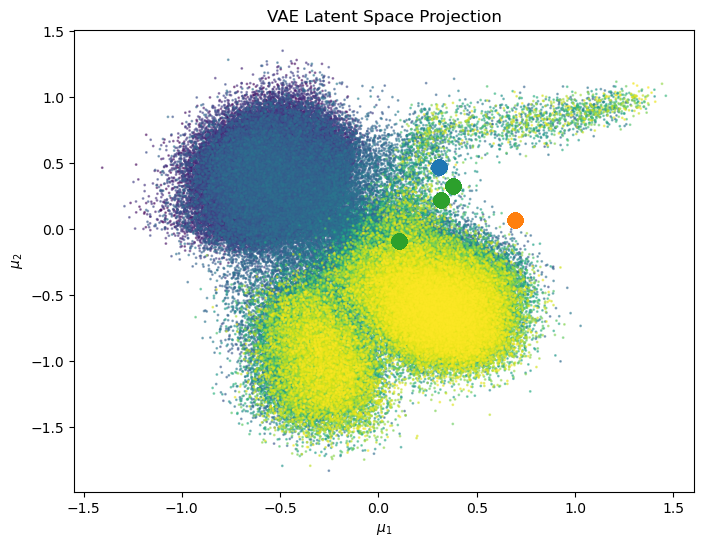

In [48]:
# Visualize Latent Space

# Project entire dataset
proj = vae_model.transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(proj[:, 0], proj[:, 1], s=1, alpha=0.5, c = np.arange(len(proj)))
plt.scatter(test_proj_al2cu[:, 0], test_proj_al2cu[:, 1], s=100, alpha=1.0)
plt.scatter(test_proj_fcc[:, 0], test_proj_fcc[:, 1], s=100, alpha=1.0)
plt.scatter(test_proj_ni3p[:, 0], test_proj_ni3p[:, 1], s=100, alpha=1.0)

plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")
plt.title("VAE Latent Space Projection")
plt.show()